### Helpers

In [69]:
#Packages for NLP
import pickle
import numpy as np
from tqdm import tqdm
import pandas as pd
import json
import string
import nltk
from nltk.corpus import stopwords
from  nltk import FreqDist
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import spacy
from textblob import TextBlob
from textblob import Word
from wordcloud import WordCloud, ImageColorGenerator
import warnings
warnings.filterwarnings('ignore')

nlp = spacy.load("en_core_web_sm")

## Getting dataframes

In [3]:
#Importing big dataframes and dataframes per year
df = pd.read_pickle('../Data-Cleaning-EDA/cleaned_full_data.pkl')
year_df = pd.read_pickle('../Data-Cleaning-EDA/cleaned_year_data.pkl')

In [4]:
print(df.shape)
df.head()

(27122, 22)


,Artist,Title,Album,duration_ms,popularity,num_markets,danceability,energy,loudness,speechiness,...,liveness,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,tokens,tokens_lemma,Count_words
0,DJ Jazzy Jeff & The Fresh Prince,Time to Chill,"He’s The DJ, I’m The Rapper",266040,24,79,0.735,0.559,-16.289,0.161,...,0.0648,0.887,170.385,4,1988,for years i have been waitin and hesitatin to ...,4.43,"[years, waitin, hesitatin, make, rap, record, ...","[years, waitin, hesitatin, make, rap, record, ...",234
1,Machine Gun Kelly,Candy,Hotel Diablo,156719,78,79,0.744,0.638,-4.860,0.049,...,0.1820,0.480,98.019,4,2019,haha big 14 you know what the fuck going on ...,2.61,"[haha, big, 14, know, Fword, going, ayy, know,...","[haha, big, 14, know, Fword, go, ayy, know, ke...",168
2,Big Pun,You Ain’t a Killer,Capital Punishment,254866,57,79,0.724,0.887,-7.076,0.393,...,0.1120,0.745,90.945,4,1998,the harsh realities of life have taken toll ev...,4.25,"[harsh, realities, life, taken, toll, even, je...","[harsh, realities, life, take, toll, even, jes...",464
3,Das EFX,Buck-Buck,Hold It Down,193626,22,78,0.791,0.783,-10.470,0.416,...,0.2950,0.531,95.677,4,1995,skoob and dray giving shoutouts chorus well ...,3.23,"[skoob, dray, giving, shoutouts, chorus, well,...","[skoob, dray, give, shoutouts, chorus, well, g...",327
4,Kool Moe Dee,To the Beat Y’all,Funke Funke Wisdom,201266,11,77,0.801,0.481,-13.903,0.232,...,0.3950,0.578,108.597,4,1991,to the beat to the beat y'all to the beat y'a...,3.35,"[beat, beat, y'all, beat, y'all, beat, y'all, ...","[beat, beat, y'all, beat, y'all, beat, y'all, ...",309


## Most frequent words

### All Lyrics

In [ ]:
#Functions to count top words and plots the frequency

In [24]:
def get_top_n_words(ngram_start, ngram_end, corpus, n=10):
    """
    List the top n words in a vocabulary according to occurrence in corpus.
    """
    vec = CountVectorizer(ngram_range = (ngram_start, ngram_end))
    bag_of_words = vec.fit_transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [25]:
def plot_top_n_ngrams(corpus, n, ngram_start, ngram_end):
    """
    Given corpus, number of top words you want, the range of 
    ngrams you're interested in (eg, just words: start = 1, end=1;
    words & bigrams: start=1, end=2), this function will graph the
    top words/ngrams in your corpus.
    """
    # get top n words
    top_words = get_top_n_words(ngram_start, ngram_end, corpus, n)
    
    # plot top n words
    fig = plt.figure(figsize=(12,6))
    ax = plt.barh([x[0] for x in top_words], [y[1] for y in top_words], 
            align='center', alpha=0.5,color='r')
    plt.title('Distribution of most frequent words')
    plt.xlabel('# times')
    plt.ylabel('Words')



In [26]:
all_lyrics = df.tokens_lemma.apply(lambda x: ' '.join([word for word in x]))

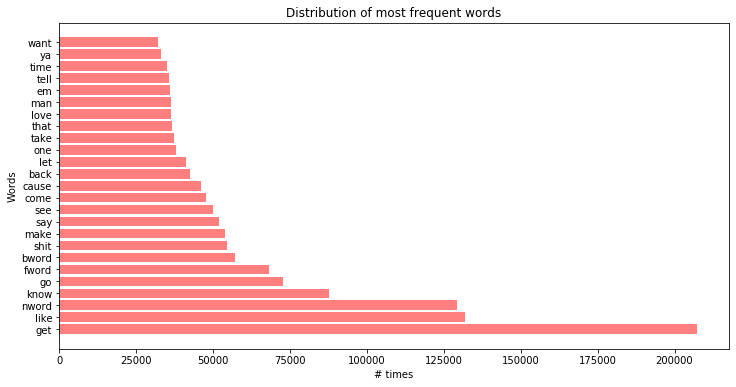

In [27]:
plot_top_n_ngrams(all_lyrics, 25, 1, 1)

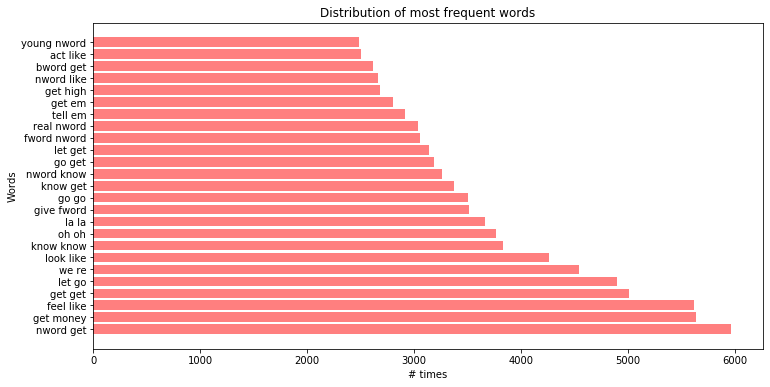

In [28]:
plot_top_n_ngrams(all_lyrics, 25, 2, 2)

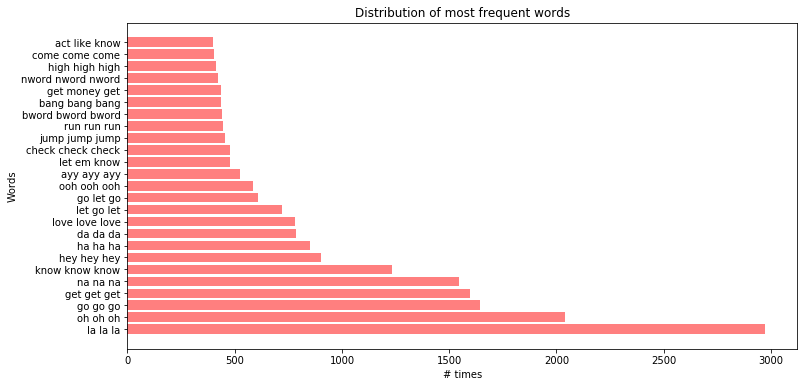

In [60]:
plot_top_n_ngrams(all_lyrics, 25, 3, 3)

## Vectorize

### TF IDF

In [61]:
df.head()

,Artist,Title,Album,duration_ms,popularity,num_markets,danceability,energy,loudness,speechiness,...,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,tokens,tokens_lemma,Count_words,Decade
0,DJ Jazzy Jeff & The Fresh Prince,Time to Chill,"He’s The DJ, I’m The Rapper",266040,24,79,0.735,0.559,-16.289,0.161,...,0.887,170.385,4,1988.0,for years i have been waitin and hesitatin to ...,4.43,"[years, waitin, hesitatin, make, rap, record, ...","[years, waitin, hesitatin, make, rap, record, ...",234,1980-90s
1,Machine Gun Kelly,Candy,Hotel Diablo,156719,78,79,0.744,0.638,-4.860,0.049,...,0.480,98.019,4,2019.0,haha big 14 you know what the fuck going on ...,2.61,"[haha, big, 14, know, Fword, going, ayy, know,...","[haha, big, 14, know, Fword, go, ayy, know, ke...",168,2010-20s
2,Big Pun,You Ain’t a Killer,Capital Punishment,254866,57,79,0.724,0.887,-7.076,0.393,...,0.745,90.945,4,1998.0,the harsh realities of life have taken toll ev...,4.25,"[harsh, realities, life, taken, toll, even, je...","[harsh, realities, life, take, toll, even, jes...",464,1990-00s
3,Das EFX,Buck-Buck,Hold It Down,193626,22,78,0.791,0.783,-10.470,0.416,...,0.531,95.677,4,1995.0,skoob and dray giving shoutouts chorus well ...,3.23,"[skoob, dray, giving, shoutouts, chorus, well,...","[skoob, dray, give, shoutouts, chorus, well, g...",327,1990-00s
4,Kool Moe Dee,To the Beat Y’all,Funke Funke Wisdom,201266,11,77,0.801,0.481,-13.903,0.232,...,0.578,108.597,4,1991.0,to the beat to the beat y'all to the beat y'a...,3.35,"[beat, beat, y'all, beat, y'all, beat, y'all, ...","[beat, beat, y'all, beat, y'all, beat, y'all, ...",309,1990-00s


In [67]:
len(df)

27122

In [68]:
#Create a list with all the lyrics
list_lyrics = df.tokens_lemma.tolist()

In [66]:
len(list_lyrics)

27122

In [70]:
#using TF-IDF to vectorize 
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(list_lyrics)

# print(X.shape)
(4, 9)

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
(4, 9)


(4, 9)

In [ ]:
print(vectorizer.get_feature_names())

## Transformation LSA and LDA